---

# Atenção!

Lembre-se de clonar este notebook antes de tentar editar as células de código.

Para isso, basta seguir os passos:

File -> Save a copy in Drive



---

Vamos começar estar aula ajustando todos os requerimentos do projeto

In [ ]:
!git clone https://github.com/loggi/loggibud
%cd /content/loggibud/

# Instale as dependências do projeto
!pip install poetry
!poetry install
# Se você estiver executando esse script localmente, não precisa dos dois comandos abaixo
!poetry export -f requirements.txt --without-hashes --output requirements.txt
!pip install -r requirements.txt

# Verifique se tudo funcionou executando os testes
!poetry run pytest -s -v tests/

# Baixe os dados compilados
!wget -nc https://loggibud.s3.amazonaws.com/dataset.zip
!unzip -n dataset.zip

# Verifique que a pasta `data/` agora não está mais vazia
!ls data/

In [ ]:
# Arquivo de configuração para acessar o OSRM
from loggibud.v1.distances import OSRMConfig


osrm_config = OSRMConfig(host="http://ec2-34-222-175-250.us-west-2.compute.amazonaws.com")
osrm_config

OSRMConfig(host='http://ec2-34-222-175-250.us-west-2.compute.amazonaws.com', timeout_s=600)

# Epílogo

A aula anterior esclareceu como, em problemas mais realistas, solvers de VRP _estático_ tendem a não ser diretamente aplicáveis. Assim, apresentamos duas propostas de algoritmos _dinâmicos_, capazes de alocar pacotes em veículos à medida em que tornam-se disponíveis para nós.

Mencionamos que um grande problema em determinar boas rotas nesse caso é o fato de não conhecermos quais pacotes chegarão e/ou em qual instante isso acontecerá. Temos no máximo os pacotes que já chegaram. Logo, nossa informação é limitada e temos que lidar da melhor maneira possível com isso.

No entanto, se pararmos para pensar, não temos apenas a informação dos pacotes que já chegaram num dado dia. Sabemos também as entregas que foram feitas _ontem_, e talvez _anteontem_, e talvez vários meses atrás. O propósito desta aula então é desenvolver um método que faça uso de informação passada para nos guiar na criação de rotas futuras. Como nos métodos anteriores, existem diversas maneiras de fazer uso disso. Vamos apresentar uma delas nesta aula.

# Resolvendo o VRP dinâmico com informação histórica

## Preliminares

A premissa que vamos assumir para utilizar este tipo de método é que _a distribuição de entregas ao longo dos dias não varia muito_. Existem métodos estatísticos rigorosos para verificar este tipo de afirmação, mas vamos assumir isso como verdade aqui.

Você agora deve estar familiarizado com o processo de carregar e desenhar uma instância, por exemplo:

In [ ]:
from loggibud.v1.types import CVRPInstance
from loggibud.v1.plotting.plot_instance import plot_cvrp_instance


file_path = "./data/cvrp-instances-1.0/train/df-0/cvrp-0-df-0.json"
problem = CVRPInstance.from_file(file_path)
plot_cvrp_instance(problem)

Observe bem o caminho `"./data/cvrp-instances-1.0/train/df-0/cvrp-0-df-0.json"`.
Ele busca na pasta `./data/cvrp-instances-1.0/train/df-0`. Vamos ver o conteúdo desta pasta:

In [ ]:
!ls ./data/cvrp-instances-1.0/train/df-0

cvrp-0-df-0.json   cvrp-0-df-30.json  cvrp-0-df-51.json  cvrp-0-df-72.json
cvrp-0-df-10.json  cvrp-0-df-31.json  cvrp-0-df-52.json  cvrp-0-df-73.json
cvrp-0-df-11.json  cvrp-0-df-32.json  cvrp-0-df-53.json  cvrp-0-df-74.json
cvrp-0-df-12.json  cvrp-0-df-33.json  cvrp-0-df-54.json  cvrp-0-df-75.json
cvrp-0-df-13.json  cvrp-0-df-34.json  cvrp-0-df-55.json  cvrp-0-df-76.json
cvrp-0-df-14.json  cvrp-0-df-35.json  cvrp-0-df-56.json  cvrp-0-df-77.json
cvrp-0-df-15.json  cvrp-0-df-36.json  cvrp-0-df-57.json  cvrp-0-df-78.json
cvrp-0-df-16.json  cvrp-0-df-37.json  cvrp-0-df-58.json  cvrp-0-df-79.json
cvrp-0-df-17.json  cvrp-0-df-38.json  cvrp-0-df-59.json  cvrp-0-df-7.json
cvrp-0-df-18.json  cvrp-0-df-39.json  cvrp-0-df-5.json	 cvrp-0-df-80.json
cvrp-0-df-19.json  cvrp-0-df-3.json   cvrp-0-df-60.json  cvrp-0-df-81.json
cvrp-0-df-1.json   cvrp-0-df-40.json  cvrp-0-df-61.json  cvrp-0-df-82.json
cvrp-0-df-20.json  cvrp-0-df-41.json  cvrp-0-df-62.json  cvrp-0-df-83.json
cvrp-0-df-21.json  cvrp-0-d

Além da instância usual `cvrp-0-df-0.json`, existem outras 89. Cada arquivo destes representa as entregas realizadas diariamente ao longo de 90 dias. Isto é válido para cada cidade e em cada região.

In [ ]:
# Verifique aqui os arquivos das outras pastas

In [ ]:
# Repita a visualização para algumas outras instâncias e verifique se as regiões de entrega tendem a ser parecidas ao longo delas

Além desta subpasta `./data/cvrp-instances-1.0/train`, existe também outra `./data/cvrp-instances-1.0/dev`. Dentro dela, temos a mesma estrutura, com a diferença de que cada região contém arquivos correspondentes a 30 dias. Neste caso, a numeração começa de 90.

In [ ]:
# Verifique aqui os arquivos destas outras pastas

Estas pastas possuem estes nomes e estas separações por um motivo. A ideia é que as instâncias em `train` representem informações históricas que já temos disponíveis por completo nos últimos 90 dias. Assim, podemos utilizar este conjunto de _treinamento_ e desenvolver um modelo capaz de receber novos pacotes e criar rotas semelhantes. Finalmente, para _testar_ este modelo, usamos as instâncias da pasta `dev`.

## Visão Geral

Uma vez entendida a estrutura dos arquivos com informações disponíveis, vamos apresentar a ideia do nosso algoritmo.

A frase "construir um modelo que receba pacotes e separe-os em rotas" pode parecer algo bastante amplo e abstrato. E na realidade é assim mesmo. Os dois algoritmos das aulas passadas são dois possíveis modelos, em que o método ingênuo não usa nenhuma informação histórica, e o segundo usa apenas a informação recebida do dia atual.

Vamos apresentar uma alternativa para ampliar ainda mais as possibilidades.

Suponha que temos as seguintes entregas de ontem e de anteontem. Como se vê nos painéis da esquerda, este perfil é razoavelmente parecido, e podemos dividir visualmente a região em três sub-regiões, cada uma com uma rota, como mostrado nos painéis à direita.

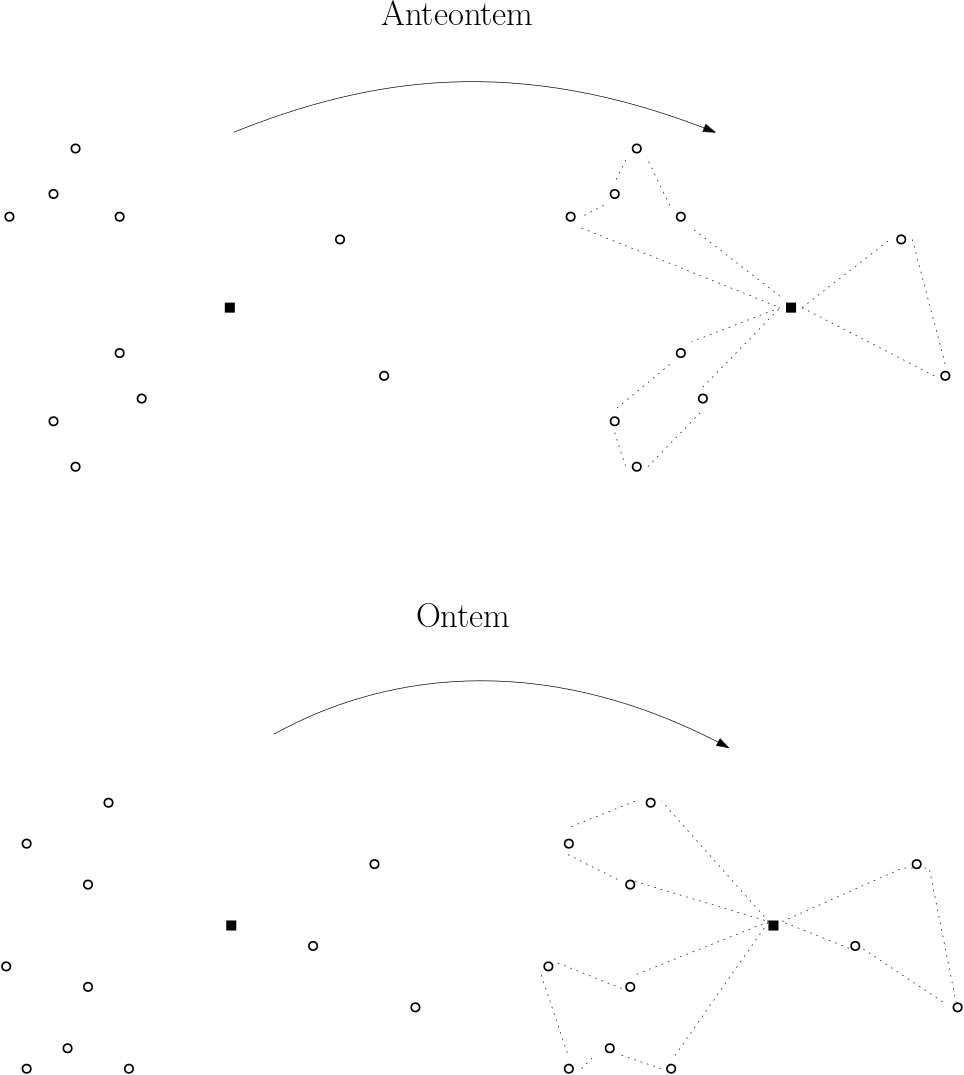

Nossa ideia consiste em usar esta ideia e efetivamente dividir o território em três sub-regiões, como ilustrado abaixo:

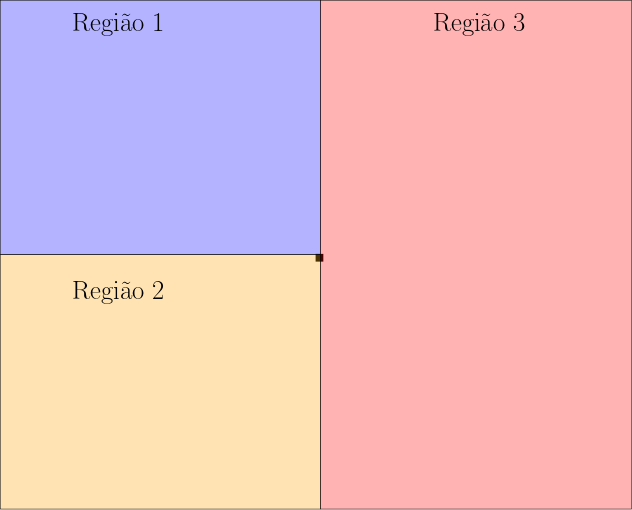

Com isso, nosso algoritmo funcionaria da seguinte forma:

1. Começamos com três veículos vazios, cada um atribuído a uma sub-região;
2. Cada vez que chegar um novo pedido, determinamos a qual região ele pertence e preenchemos o veículo correspondente;
3. Assim que um veículo atingir seu limite, nós usamos o TSP para construir uma rota com seus pedidos, e abrimos um novo veículo vazio nesta sub-região.

O processo continua até que todos os pacotes sejam roteirizados.

Por exemplo, na imagem a seguir,

1. Pedido 1 é incluído no veículo 1,
2. Pedido 2 é incluído no veículo 3,
3. Pedido 3 é incluído no veículo 2,
4. Pedido 4 é incluído no veículo 1.

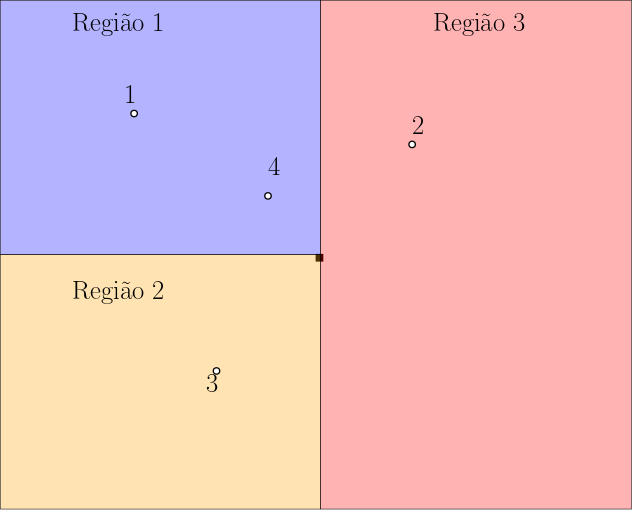

A ideia é bastante simples, mas podemos ter algumas dúvidas, como:

- Como dividir o território em sub-regiões? Apenas retângulos são válidos?
- Qual o número adequado de sub-regiões?
- Como determinar a região à qual um pedido novo pertence?

As respostas para estas perguntas dependem do modelo que escolhermos, então não há soluções universais para todos os casos. De fato, ao final deste curso você deverá ser capaz de criar um novo modelo e responder a estas perguntas por sua conta!

Neste exemplo, usamos retângulos limitados ao território onde há entregas. E há três deles porque nas informações históricas precisamos de três rotas em cada dia. Observe também que os tamanhos destes retângulos não foram criados ao acaso. No passado houve mais entregas nas regiões 1 e 2, logo criando um terceiro retângulo maior pode ajudar a equilibrar a número de entregas em cada um.

Todos estes parâmetros foram pensados e resolvidos de forma conceitual. Vamos tentar então desenvolver uma ideia parecida a seguir.

## Um algoritmo baseado em K-médias

Em vez de retângulos, vamos aqui adotar métodos baseados em [clusters aglomerativos](https://towardsdatascience.com/agglomerative-clustering-and-dendrograms-explained-29fc12b85f23). Em simples palavras, eles procuram agrupar um conjunto de pontos em subconjuntos próximos, assim como fizemos visualmente na análise anterior. Mas claro, desta vez o processo é automático.

Vamos por exemplo agrupar todos os dados que temos já disponíveis:

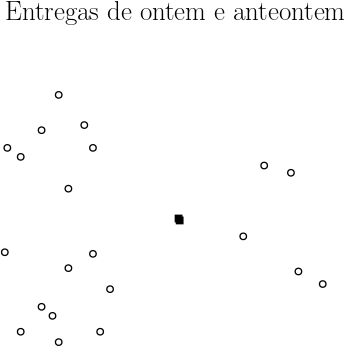

Um dos algoritmos dessa classe de clusters é o [K-médias](https://en.wikipedia.org/wiki/K-means_clustering). Aqui, K é o número de clusters desejados. O que ele faz é determinar pontos auxiliares chamados _centroides_ para representar, como o nome diz, o centro de cada cluster. Então, ficaríamos com algo do tipo:

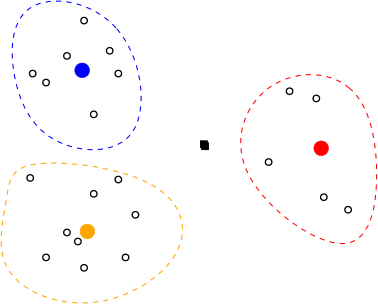

Estes centroides têm como coordenadas a média aritmética das coordenadas de cada ponto em seu cluster (daí o nome K-means).

Com isso, nossa região de entregas está dividida como antes em três sub-regiões, exceto que em vez de retângulos usamos centroides.

E finalmente, dado um novo pedido, como determinar a qual sub-região ele pertence? Simples, basta determinar qual centroide está mais próximo dele. Em termos visuais, cada sub-região poderia ser representada por círculos, como mostrado abaixo:

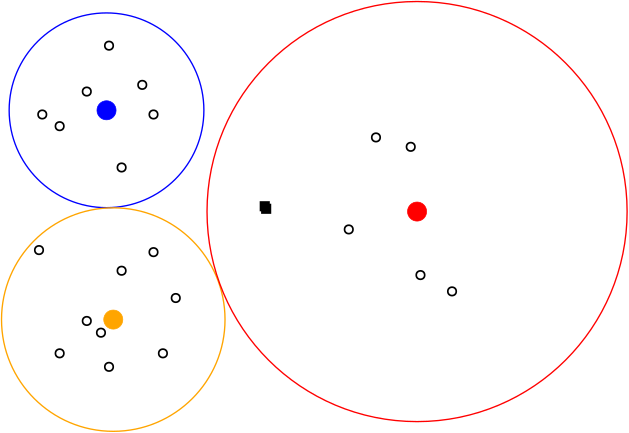

## Implementação

Vamos como antes começar com uma instância de treino simplificada, com apenas as primeiras dez entregas:

In [ ]:
from loggibud.v1.types import CVRPInstance

file_path = "./data/cvrp-instances-1.0/train/df-0/cvrp-0-df-0.json"
instance = CVRPInstance.from_file(file_path)

# Limita a apenas as primeiras dez entregas
instance.deliveries = instance.deliveries[:10]

# Limita a capacidade dos veículos
instance.vehicle_capacity = 20

Vamos supor que a região de entregas será dividida em 3 subregiões. Precisamos então de uma forma de agrupar estes 10 pontos e determinar 3 centroides para cada grupo.

Para isso, vamos usar o método K-médias como explicado antes. Para nossa simplicidade, já existe [uma biblioteca em Python](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) pronta para nos ajudar, então vamos importá-la:

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

Vamos primeiro extrair as coordenadas de cada entrega na forma `(lat, lng)` com o seguinte código:

In [ ]:
points = []
for delivery in instance.deliveries:
    points.append((delivery.point.lat, delivery.point.lng))

# Converte a lista em uma matriz numpy, necessário para usar o KMeans
points = np.array(points)
points

array([[-15.65879313, -47.7496622 ],
       [-15.65144038, -47.75887552],
       [-15.65120731, -47.75501881],
       [-15.64870644, -47.75878539],
       [-15.66047287, -47.75284167],
       [-15.66338875, -47.74788198],
       [-15.64835551, -47.75836163],
       [-15.69666125, -47.71947512],
       [-15.66897487, -47.76340111],
       [-15.65435446, -47.75482461]])

De posse das coordenadas das entregas, usamos a classe `KMeans` para calcular os centroides desejados

In [ ]:
model = KMeans(n_clusters=3, random_state=0).fit(points)
model

KMeans(n_clusters=3, random_state=0)

Aqui, `n_clusters` é o número de sub-regiões desejadas, e `random_state` é uma variável que chamamos com 0 para que sempre obtenhamos os mesmos resultados toda vez que rodar este comando.

A variável `model` contém tudo que precisamos para o nosso método:

In [ ]:
# Estas são as coordenadas dos nossos centroides
model.cluster_centers_

array([[-15.66290741, -47.75344674],
       [-15.69666125, -47.71947512],
       [-15.65081282, -47.75717319]])

In [ ]:
# Estes são os índices indicando qual sub-região cada entrega pertence
model.labels_

array([0, 2, 2, 2, 0, 0, 2, 1, 0, 2], dtype=int32)

Consulte a documentação caso tenha curiosidade em outras propriedades.

O que precisamos agora é, dada uma nova entrega, determinar em qual sub-região ela deverá pertencer. Para isso, poderíamos calcular a distância desta entrega para cada elemento em `model.cluster_centers_`. Felizmente, para os nossos propósitos, já existe um método chamado `predict` que faz algo parecido.

Imagine que a próxima entrega tem as mesmas coordenadas da primeira:

In [ ]:
delivery = instance.deliveries[0]
delivery

Delivery(id='ed0993f8cc70d998342f38ee827176dc', point=Point(lng=-47.7496622016347, lat=-15.65879313293694), size=10)

Para usar o método `predict`, precisamos das coordenadas de `delivery`:

In [ ]:
delivery_point = np.array([(delivery.point.lat, delivery.point.lng)])
delivery_point

array([[-15.65879313, -47.7496622 ]])

In [ ]:
# Assim, aqui está o resultado de `predict`
model.predict(delivery_point)

array([0], dtype=int32)

Este resultado 0 indica que esta entrega deveria pertencer à sub-região 0.
Verifique em `model.labels_` como a primeira entrega (com as mesmas coordenadas) já pertence a ela, o que é um resultado esperado.

Com toda esta discussão, o nosso algoritmo funcionaria assim:

1. Etapa 1 de Pré-treino: agrupe todas as instâncias completas disponíveis e construa um modelo KMeans com eles;
2. Etapa 2 de Execução: para cada novo pacote, determine para qual sub-região ele deve pertencer.

Com respeito aos veículos, iniciamos com um veículo vazio em cada sub-região, que é preenchido aos poucos. Caso o pacote chegando não caiba mais, finalizamos esta rota como na aula de antes, organizamos a ordem de entregas com o TSP, e abrimos um novo veículo com este pacote.

Para buscar as instâncias de treinamento, precisamos do caminho da pasta e iterar em cada arquivo. Analise o código a seguir:

In [ ]:
from pathlib import Path

from loggibud.v1.types import CVRPInstance


def _load_instances(train_path_str):
    # Converte o nome da pasta em uma variável `Path`
    train_path = Path(train_path_str)

    instances = []
    for instance_file in train_path.iterdir():
        instance = CVRPInstance.from_file(instance_file)
        instances.append(instance)

    return instances

# Pode ser que isto leve um tempo para carregar
instances = _load_instances("./data/cvrp-instances-1.0/train/df-0")
instances

Observe como ele retorna todas as instâncias da pasta `./data/cvrp-instances-1.0/train/df-0` no formato `CVRPInstance`.

Agora, extraímos as coordenadas de todas as entregas e usamos na nossa função de pré-treino:

In [ ]:
def _get_delivery_coordinates(instance):
    """Extrai as coordenadas de uma entrega"""
    points = []
    for delivery in instance.deliveries:
        points.append((delivery.point.lat, delivery.point.lng))

    # Converte a lista de pontos em uma matrix numpy
    return points

# Experimente com uma das instâncias
_get_delivery_coordinates(instances[0])

Com isso, nossa função de treino fica

In [ ]:
def pretrain(instances, n_clusters):
    # Busque os pontos de cada entrega e combine todos em uma lista
    all_points_list = []
    for instance in instances:
        all_points_list.extend(_get_delivery_coordinates(instance))

    # Converta a lista em uma matriz para o `KMeans`
    points = np.array(all_points_list)

    # Constrói o modelo com KMeans
    model = KMeans(n_clusters=n_clusters, random_state=0).fit(points)
    return model

# Experimente dividir a região em 10 sub-regiões
model = pretrain(instances, 10)
model

KMeans(n_clusters=10, random_state=0)

In [ ]:
# Verifique que temos dez centroides

A primeira etapa está pronta.

Vamos agora supor que estamos em um dia de trabalho, e nossa instância de teste corresponde ao arquivo `./data/cvrp-instances-1.0/dev/df-0/cvrp-0-df-90.json`, ou seja, ao nonagésimo primeiro dia.

In [ ]:
problem = CVRPInstance.from_file("./data/cvrp-instances-1.0/dev/df-0/cvrp-0-df-90.json")
problem

CVRPInstance(name='cvrp-0-df-90', region='df-0', origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), vehicle_capacity=180, deliveries=[Delivery(id='50a13dc4e175645e22d7eac9c9ee35c5', point=Point(lng=-47.75847657230832, lat=-15.652541341978136), size=6), Delivery(id='e98f946594f5939271c3b82e439ff71c', point=Point(lng=-47.756701028749525, lat=-15.65232270602603), size=1), Delivery(id='c0b320558716e0cf15ce45d8b8189046', point=Point(lng=-47.7609277270516, lat=-15.65246980577859), size=7), Delivery(id='d1dd282d0b84b27e945f016c08447d2a', point=Point(lng=-47.75623444551221, lat=-15.659632429949554), size=10), Delivery(id='52dd17bd1b75c883a4b665e96d95e3d', point=Point(lng=-47.74744591667285, lat=-15.701436474802009), size=3), Delivery(id='79aa37298cd61e575191af560cd93650', point=Point(lng=-47.72718704525455, lat=-15.628607686615675), size=4), Delivery(id='9742cf900fa7927783690026d3ab797d', point=Point(lng=-47.73346092903645, lat=-15.632251022011443), size=3), Delivery(id='a8d59afb3

Como antes, simularemos os pacotes chegando aos poucos com um `for`. O que precisaremos então é de uma função `route` que recebe nosso `model`, o pacote que está chegando, e tenta alocá-lo a uma sub-região.

In [ ]:
# Teste este código com a primeira entrega em `problem.deliveries`
delivery = problem.deliveries[0]
delivery_point = np.array([(delivery.point.lat, delivery.point.lng)])

subregion_index = model.predict(delivery_point)[0]
subregion_index


0

Logo, este primeiro pacote iria para a sub-região de índice 0 (mas pode ser que o número mude em sua execução).

Precisamos de uma varíavel para armazenar as rotas em construção que existem em cada uma:

In [ ]:
subroutes = {}
for i in range(10):
    subroutes[i] = []
subroutes

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

`subroutes` é um dicionário inicializado com uma lista vazia em cada sub-região. Com isso, podemos usar `subregion_index` para saber em qual delas o novo pacote deve pertencer, testar se o veículo o suporta e, caso contrário, finalizar esta rota e criar uma nova do zero.

Com isso, aqui está o código completo do nosso solver. Analise-o com bastante atenção. Grande parte das funções foram simplesmente reproveitadas da aula anterior.

In [ ]:
import numpy as np
from ortools.constraint_solver import pywrapcp
from sklearn.cluster import KMeans

from loggibud.v1.distances import calculate_distance_matrix_m, OSRMConfig
from loggibud.v1.types import CVRPInstance, CVRPSolution, CVRPSolutionVehicle


def pretrain(instances, n_clusters):
    # Busque os pontos de cada entrega e combine todos em uma lista
    all_points_list = []
    for instance in instances:
        all_points_list.extend(_get_delivery_coordinates(instance))

    # Converta a lista em uma matriz para o `KMeans`
    points = np.array(all_points_list)

    # Constrói o modelo com KMeans
    model = KMeans(n_clusters=n_clusters, random_state=0).fit(points)
    return model


def solve_vrp_kmeans(problem, model):
    """"""
    # Inicializa o dicionário com sub-rotas
    num_clusters = model.n_clusters
    subroutes = {}
    for i in range(num_clusters):
        subroutes[i] = []

    # Inicializa a variável com os veículos completos
    vehicles = []

    # Resolve o problema dinamicamente
    for delivery in problem.deliveries:
        route(problem, model, delivery, subroutes, vehicles)

    # Para cada sub-rota sobrando em `subroutes`, construa um novo veículo
    for subroute in subroutes.values():
        vehicle_solution = _construct_vehicle(problem, subroute)
        vehicles.append(vehicle_solution)

    # Ao final, retorne uma variável do tipo `CVRPSolution`
    return CVRPSolution(name=problem.name, vehicles=vehicles)


def route(problem, model, delivery, subroutes, vehicles):
    """"""
    delivery_point = np.array([(delivery.point.lat, delivery.point.lng)])
    subregion_index = model.predict(delivery_point)[0]

    # Verifica se o veículo em `subregion_index` comporta o novo pacote
    if (
        _compute_vehicle_volume(subroutes[subregion_index]) + delivery.size
        <= problem.vehicle_capacity
    ):
        subroutes[subregion_index].append(delivery)
    else:
        # Finaliza a rota atual
        vehicle_solution = _construct_vehicle(
            problem, subroutes[subregion_index]
        )
        vehicles.append(vehicle_solution)

        # Adiciona um novo veículo a esta sub-região
        subroutes[subregion_index] = [delivery]


def _compute_vehicle_volume(deliveries):
    volume = 0
    for delivery in deliveries:
        volume += delivery.size
    return volume


def _construct_vehicle(problem, vehicle_deliveries):
    distance_matrix = _compute_distance_matrix(problem, vehicle_deliveries)
    ordered_indices, _ = solve_tsp_ortools(distance_matrix)

    # `ordered_indices` tem o formato `[0, 4, 3, 1, ..., 0]`. Precisamos
    # remover a origem do início e do final e ordenar a variável
    # `vehicle_deliveries` usando estes índices
    ordered_vehicle_deliveries = []
    for ordered_index in ordered_indices[1:-1]:
        ordered_vehicle_deliveries.append(
            vehicle_deliveries[ordered_index - 1]
        )

    return CVRPSolutionVehicle(
        origin=problem.origin, deliveries=ordered_vehicle_deliveries
    )


def _compute_distance_matrix(problem, vehicle_deliveries):
    # Os pontos do problema consistem na origem mais as entregas em
    # `vehicle_deliveries`
    points = [problem.origin]
    for delivery in vehicle_deliveries:
        points.append(delivery.point)

    # Configuração com o servidor para os alunos
    return calculate_distance_matrix_m(points, config=osrm_config)


def solve_tsp_ortools(distance_matrix):
    n = distance_matrix.shape[0]  # número de nós do problema
    num_vehicles = 1  # número de veículos (no nosso caso, apenas um)
    depot_node = 0  # número do nó que representa o ponto de origem
    manager = pywrapcp.RoutingIndexManager(n, num_vehicles, depot_node)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(i, j):
        # `i` e `j` são índices internos do OR-Tools. Precisamos primeiro
        # convertê-los em nós do nosso problema
        ni = manager.IndexToNode(i)
        nj = manager.IndexToNode(j)
        return distance_matrix[ni, nj]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Resolve o problema com métodos default
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    solution = routing.SolveWithParameters(search_parameters)

    # Constroi a rota final
    route = []
    index = routing.Start(0)
    node = manager.IndexToNode(index)
    route.append(node)

    while not routing.IsEnd(index):
        index = solution.Value(routing.NextVar(index))
        node = manager.IndexToNode(index)
        route.append(node)

    return route, solution.ObjectiveValue()

In [ ]:
# Experimente executá-lo com o novo problema (pode levar um tempo, já que estamos resolvendo uma instância completa aqui)
solution = solve_vrp_kmeans(problem, model)
solution

CVRPSolution(name='cvrp-0-df-90', vehicles=[CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='91258812c54dacd6bd8bafe3844b7d62', point=Point(lng=-47.77576468973916, lat=-15.764746563232405), size=2), Delivery(id='e521bd48bc0ee2bb56b6af7d04de8edb', point=Point(lng=-47.775875157499705, lat=-15.766284481797888), size=5), Delivery(id='e77f788c1ae8a9a2957ea6883983a051', point=Point(lng=-47.77600929309777, lat=-15.76557136497402), size=8), Delivery(id='61b0cef5222e6a32a8f43b2817e84f41', point=Point(lng=-47.77882466888445, lat=-15.767908074531041), size=9), Delivery(id='492da543290f9f5c12cb07b1f704ac83', point=Point(lng=-47.779758428195166, lat=-15.767559287377336), size=6), Delivery(id='492da543290f9f5c12cb07b1f704ac83', point=Point(lng=-47.779758428195166, lat=-15.767559287377336), size=6), Delivery(id='e435f3bc081f4bf6a9d41ac196cb4ede', point=Point(lng=-47.78047156217494, lat=-15.768057649310924), size=8), Delivery(id='b87cd660da5b

In [ ]:
from loggibud.v1.eval.task1 import evaluate_solution


total_distance = evaluate_solution(problem, solution, config=osrm_config)
print(f"O percurso completo leva {total_distance} km")

O percurso completo leva 2031.7586 km


In [ ]:
from loggibud.v1.plotting.plot_solution import plot_cvrp_solution


plot_cvrp_solution(solution)

## Como determinar o número de sub-regiões?

Até o momento nós temos fornecido um número (quase ao acaso) de sub-regiões. Determinar um valor apropriado é quase um outro problema por si só. Apesar disso, aqui estão algumas sugestões:

- Lembre-se da logística que deve ocorrer no galpão onde os pacotes chegam. Em alguns casos há um limite de quantos veículos podem chegar por vez, ou restrições do espaço disponível. Por exemplo, se nosso estacionamento comporta apenas 20 veículos por vez, então é adequado limitarmos o espaço a 20 sub-regiões. Ou então, se nosso galpão tem um tamanho tal que podemos dividi-lo em até 10 corredores, então nosso número seria 10.

- Experimente analisar visualmente as entregas históricas em cada dia. É possível observar padrões e clusters nestes dados que nos levem a determinar um número adequado de sub-regiões?

- No contexto do K-médias, existem [estratégias para determinar um número bom para K](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set). Este tipo de investigação pode ser útil também.

# Agora é com você!

Com esta aula, finalizamos três diferentes aboragens para resolver o VRP dinâmico, que é o foco do nosso desafio. Claramente, estamos longe de esgotar as possibilidades de algoritmos para isso e, de fato, não é possível saber se os que já conhecemos são realmente bons. Esta é a sua tarefa neste desafio.

O objetivo aqui é desenvolver um algoritmo para resolver o Problema de Roteamento de Veículos Dinâmico. Para isso, você tem a liberdade de usar qualquer estratégia como algoritmo.

Um ponto importante é que os códigos desenvolvidos em todo este curso focaram no entendimento e não na eficiência. Portanto, desenvolva seu algoritmo usando os paradigmas, as bibliotecas e técnicas de código que preferir.

Aqui está uma sugestão de estrutura que seu código pode seguir:

```python
class MySolver:
    param1
    param2
    param3
    ...

    def pretrain(self, instances: List[CVRPInstance]):
        """Recebe instâncias de treinamento e ajusta seus parâmetros internos"""

    def finetune(self, delivery: Delivery):
        """Recebe uma entrega atual e possivelmente reajusta algum parâmetro"""

    def route(self, delivery: Delivery):
        """
        Recebe uma entrega atual e decide:
            - ou para qual veículo atual ele deve ser enviado;
            - ou se devemos abrir um novo veículo
        """

    def finish(self) -> CVRPSolution:
        """Chamada quando sabemos que todos os pacotes do dia foram roteados
        Pode ser usada para organizar variáveis ou tratar a última rota, por
        exemplo
        """
```

E claro, use quaisquer subfunções para deixar seu código mais organizado.

Daí, o solver poderia ser executado assim:

```python
def solve(train_instances, problem):
    solver = MySolver()

    # Treina o solver com as instancias conhecidas
    solver.pretrain(train_instances)

    for delivery in problem.deliveries:
        solver.finetune(delivery)
        solver.route(delivery)

    # Retorna uma solution na forma `CVRPSolution`
    return solver.finish()
```

que ao final retornaria uma solução `CVRPSolution` com o mesmo formato que temos trabalhado.

Experimente converter o nosso solver K-médias nesta estrutura (Exercício 4).

# Resumo



Agora é com você!

Com esta aula finalizamos três diferentes abordagens para resolver o VRP dinâmico. E com isso temos também bem estabelecida a tarefa deste curso.

O objetivo é desenvolver um modelo que consiga atribuir um pedido a um veículo à medida que este pedido se torna disponível. Para isso temos à disposição dados de entregas históricoas, que podem ser usados (ou não) da forma como bem entenderem.

# Exercícios


## Exercício 1


**Construa uma função de treinamento que receba uma pasta com arquivos de treinamento e o número desejado de sub-regiões e retorne um modelo baseado em K-médias.**

Esta etapa foi construída aos poucos durante a discussão e para a pasta específica `"./data/cvrp-instances-1.0/train/df-0`. Generalize isso organizando as funções da seção de Implementação.

Experimente treinar um modelo com esta mesma pasta para K com os valores 10, 50 e 100. Em cada caso, verifique se o número de centroides foi criado corretamente.

In [ ]:
# Programe aqui sua solução

## Exercício 2

**Resolva o problema `cvrp-0-pa-100.json` da região `pa-0` com o solver baseado em K-médias dividindo a região em 10 sub-regiões.**

Dica: o conjunto de treinamento está em `"./data/cvrp-instances-1.0/train/pa-0"`. Utilize o algoritmo do exercício anterior para treinar o modelo e a função `solve_vrp_kmeans` para resolvê-lo.

In [ ]:
# Programe aqui sua solução

## Exercício 3

**Resolva o problema tratado nesta seção (`cvrp-0-df-90.json` da região `df-0`), variando o valor de K entre 10, 30, 50 e 100. Compare as rotas e as distâncias totais em cada caso.**

Use este resultado como uma análise inicial da influência de K na solução final. Você consegue determinar algum padrão?

In [ ]:
# Programe aqui sua solução

## Exercício 4

**Reescreva o nosso solver K-médias usando a estrutura da última seção. Coloque 10 como número padrão de sub-regiões, e teste com o mesmo problema do Exercício 2.**

In [ ]:
# Programe aqui sua solução

## Exercício Suplementar 1

Repita o Exercício 3 seguindo [esta análise](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) para determinar o que seria o ótimo valor de K. Compare os resultados com os obtidos com os valores de antes.

In [ ]:
# Programe aqui sua solução

## Exercício Suplementar 2

Pense em como seria uma implementação do primeiro método que divide a região em retângulos, descrita na seção de "Visão Geral". Apesar de conceitualmente mais simples, será que este método seria também mais fácil de ser implementado?

Pense bem em fatores como
- Como determinar os limites de cada retângulo?
- Como determinar seus tamanhos?
- Como descobrir a qual retângulo um novo pedido pertence?

## Exercício Suplementar 3

Busque entender os modelos implementados no repositório (no caminho `loggibud/v1/task2`. Um deles é o K-médias, bem parecido com a nossa implementação daqui. O outro faz um "sweep" no espaço, dividindo cada sub-região em "fatias de uma pizza".

Analise os dois modelos para usar como exemplos sobre o que é possível fazer para resolver o problema.

## Tarefa de casa: O Desafio LoggiBUD

A tarefa desta etapa consiste no desafio propriamente dito. Na primeira aula você teve um contato inicial com o problema e com um algoritmo simples mas ingênuo. Sua tarefa nesta etapa será então desenvolver um algoritmo para resolver o Problema de Roteamento de Veículos Dinâmico para a instância `cvrp-1-df-102.json`.

Assim:
- Caminho com instâncias de treino: `./data/cvrp-instances-1.0/train/df-1`;
- Caminho do problema: `./data/cvrp-instances-1.0/dev/df-1/cvrp-1-df-102.json`.

Busque nesta aula como ler a pasta de treino e convertê-la em uma lista com instâncias. Se quiser, pode consultar a solução do Exercício 4 também.

Crie um novo notebook com o caminho "File -> New Notebook". Nele, você terá liberdade para desenvolver seu algoritmo com a estrutura que desejar. Não é necessário seguir o formato da seção "Agora é com você"; use-o apenas como sugestão. Desenvolva quantas células precisar para organizar o seu código, ou se quiser escreva no seu editor de texto ou IDE favorita e copie-o depois.

As únicas restrições que devem ser respeitadas são:
1. Seu algoritmo deve ser respeitar a interface do repositório, i.e., deve conseguir lidar com variáveis do tipo `CVRPInstance` e retornar uma `CVRPSolution`;
2. Ele deve obedecer a condição dinâmica do problema, i.e., deve ser capaz de receber um pedido e organizá-lo num veículo _antes_ de receber o próximo. Não é permitido acumular entregas antes e roteá-las depois;
3. Uma exceção óbvia são as instâncias do conjunto de treinamento. Nelas você pode assumir que todos os pontos são conhecidos de uma vez;
4. A solução final deve ser factível, ou seja, deve passar pela função `evaluate_solution` sem levantar erros.

Aqui está um exemplo de célula final:

```python
def solve(train_instances, problem):
    # Rode qualquer código aqui usando funções de outras células,
    # como pré-treino, inicialização de variáveis etc.

    for delivery in problem.deliveries:
        # Rode qualquer outro código de forma que esta `delivery`
        # seja alocada a um veículo ao final deste loop

# Use este espaço para qualquer pós-processamento, como criação
# da variável de solução
return solution
```

Observe que a estrutura sugerida na seção "Agora é com você" e no Exercício 4 segue este formato.

Depois de desenvolver o seu algoritmo, você irá enviar sua solução num formato .json como nas duas tarefas anteriores. Da mesma forma que na segunda etapa o arquivo json possuía alguns campos a mais, aqui você fará a mesma coisa.

Os novos campos de que precisaremos são:

- Distância total em quilômetros;
- Breve descrição de como funciona seu algoritmo;
- Link para o seu notebook com o código completo.

Aqui está um exemplo de como ficaria a solução do algoritmo desta aula:



In [ ]:
# Vamos usar a solução do último problema desta aula
# (se retornar um erro, rode novamente todas as células)
solution

In [ ]:
from dataclasses import dataclass

# Vamos acrescentar os campos desejados
@dataclass
class CVRPSolutionFinal(CVRPSolution):
    total_distance_km: float
    description: str
    notebook_link: str

# Vamos criar aqui uma variável com a descrição do código
description = """
Algoritmo que divide a região de entrega em sub-regiões. Usamos dados históricos
de uma região, e com o algoritmo de clusterização K-médias cada sub-região será
representada por um centroide.

Na etapa de execução, começamos com um veículo vazio em cada sub-região. Cada
vez que uma entrega chega, ela é enviada para a sub-região de centroide mais
próximo, e adicionada ao veículo atual se houver espaço. Caso contrário,
finalizamos esta rota e abrimos um novo veículo aí. O procedimento continua até
que todos os pacotes estejam organizados em rotas.
"""

# Link do notebook:
notebook_link = "https://colab.research.google.com/drive/1pYi55RnagpT7KTTjCp_IPRVQuhjuu5iF?usp=sharing"

# Construímos a nova solução
solution_final = CVRPSolutionFinal(
    name=solution.name,
    vehicles=solution.vehicles,
    total_distance_km=evaluate_solution(problem, solution, config=osrm_config),
    description=description,
    notebook_link=notebook_link,
)

solution_final

O link do notebook pode ser encontrado no menu "Share", no topo direito da página. Daí, na parte de baixo da janela que se abrir, clique em "Copy link" e cole o resultado no código.

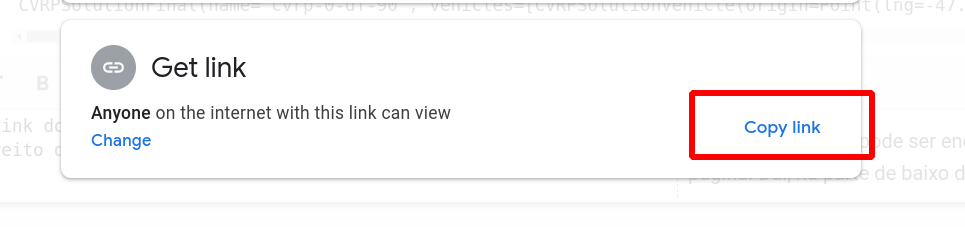

In [ ]:
# Observe as novas propriedades desta variável:
solution_final.total_distance_km

In [ ]:
solution_final.description

In [ ]:
solution_final.notebook_link

Com isso, basta seguir os passos de antes e usar a função

```python
solution_final.to_file("/content/drive/MyDrive/solution_final.json")
```

para criar um arquivo `.json` em seu drive e enviá-lo como resultado da tarefa. O nome do arquivo não precisa ser este; qualquer nome desde que venha com o formato `.json` basta.

Dicas:
- Você não será penalizado por uma solução ruim, então não se preocupe em começar com um algoritmo pouco eficiente para tentar melhorá-lo depois. Lembre: este é um problema difícil, e é estudado há anos por pesquisadores.

- Não é obrigatório usar as instâncias de treinamento. E se quiser, não é preciso nem usar todas as instâncias. Os algoritmos desenvolvidos na aula anterior, por exemplo, não fazem uso delas. Ainda não há uma resposta definitiva sobre se informações históricas ajudam ou atrapalham no fim das contas, então fique à vontade para seguir como seu coração mandar.

- Uma sugestão para se ter ideia do quão boa ou ruim sua solução está é compará-la com a resposta do LKH-3 e do algoritmo ingênuo. Para o LKH-3, nós assumimos que conhecemos todas as entregas de uma vez, então via de regra sua solução deveria ser uma das melhores possíveis. Por outro lado, o algoritmo ingênuo não tenta fazer nenhuma otimização, então sua solução deve ser uma das piores. Para o problema proposto, aqui estão as respostas que encontrei:
    - LKH-3: Distância total igual a 4297.4514 km
    - Algoritmo ingênuo: Distância total igual a 6911.6239 km (observe que usei o algoritmo ingênuo com TSP. A solução do ingênuo deve ser muito pior).

  Se a solução de seu algoritmo estiver entre estas duas, você provavelmente está num caminho bom. E se for _melhor_ que o LKH-3, você provavelmente está num caminho _muito_ bom.